<a href="https://colab.research.google.com/github/BarkinTopcu/educational_crypto_bot/blob/main/bitcoin_forecasting_edu/XGBoost_BTC_Forecast_30min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🔔 Disclaimer | Yasal Uyarı

**English:**

🚨 This project is strictly for **educational use only**.  
- It does **not provide financial or investment advice**.  
- The developer is **not responsible** for any financial loss.  
- Use **only in test environments** or simulations.

**Türkçe:**

❗️Bu proje **yatırım tavsiyesi değildir**.  
- Yalnızca **eğitim ve araştırma** amacıyla geliştirilmiştir.  
- Finansal kayıplardan geliştirici **sorumlu değildir**.  
- Sadece **test ortamlarında** ya da **simülasyonlarda** kullanınız.

---

✅ Lütfen bu projeyi kullanmadan önce yukarıdaki uyarıları dikkatlice okuyunuz.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

In [77]:
btc30 = pd.read_csv("btc_data_30min.csv")

In [78]:
btc30.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'num_trades', 'taker_buy_base', 'taker_buy_quote',
       'ignore', 'year', 'month', 'day', 'hour', 'minute', 'target', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15'],
      dtype='object')

In [79]:
btc30.drop(columns=["target","lag_1","lag_2","lag_3","lag_4","lag_5","lag_6","lag_7","lag_8","lag_9","lag_10","lag_11","lag_12","lag_13","lag_14","lag_15"],inplace=True)

In [80]:
btc30.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'num_trades', 'taker_buy_base', 'taker_buy_quote',
       'ignore', 'year', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [81]:
btc30['target'] = btc30['close'].shift(-1)
for i in range(1, 16):
    btc30[f'lag_{i}'] = btc30['close'].shift(i)

In [82]:
btc30['rolling_mean_5'] = btc30['close'].rolling(window=5).mean()
btc30['rolling_mean_3'] = btc30['close'].rolling(window=3).mean()
btc30['rolling_std_5'] = btc30['close'].rolling(window=5).std()
btc30['ema_5'] = btc30['close'].ewm(span=5).mean()

In [83]:
btc30['return_1'] = btc30['close'].pct_change(1)
btc30['return_3'] = btc30['close'].pct_change(3)
btc30['return_5'] = btc30['close'].pct_change(5)

# Hacim ilişkili
btc30['volume_change'] = btc30['volume'].pct_change()
btc30['taker_ratio'] = btc30['taker_buy_base'] / btc30['volume']

# Fiyat aralığı & mum formasyonu
btc30['high_low_range'] = btc30['high'] - btc30['low']
btc30['candle_body'] = (btc30['close'] - btc30['open']).abs()

In [84]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

btc30['rsi_14'] = compute_rsi(btc30['close'])

# MACD ve Signal
ema12 = btc30['close'].ewm(span=12, adjust=False).mean()
ema26 = btc30['close'].ewm(span=26, adjust=False).mean()
btc30['macd'] = ema12 - ema26
btc30['macd_signal'] = btc30['macd'].ewm(span=9, adjust=False).mean()

# Zaman davranışları
btc30['is_night'] = (btc30['hour'] < 6) | (btc30['hour'] > 20)


In [85]:
btc30.replace([np.inf, -np.inf], np.nan, inplace=True)

In [86]:
btc30.dropna(inplace=True)

In [99]:
print(btc30[['target', 'close']].head(10))

      target     close
15  13618.51  13598.73
16  13550.97  13618.51
17  13662.33  13550.97
18  13738.98  13662.33
19  13747.25  13738.98
20  13550.00  13747.25
21  13600.02  13550.00
22  13490.70  13600.02
23  13544.98  13490.70
24  13617.01  13544.98


In [87]:
train_size = int(len(btc30) * 0.97)
train = btc30[:train_size]
test = btc30[train_size:]

In [100]:
train.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'num_trades', 'taker_buy_base', 'taker_buy_quote',
       'ignore', 'year', 'month', 'day', 'hour', 'minute', 'target', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'rolling_mean_5', 'rolling_mean_3', 'rolling_std_5', 'ema_5',
       'return_1', 'return_3', 'return_5', 'volume_change', 'taker_ratio',
       'high_low_range', 'candle_body', 'rsi_14', 'macd', 'macd_signal',
       'is_night'],
      dtype='object')

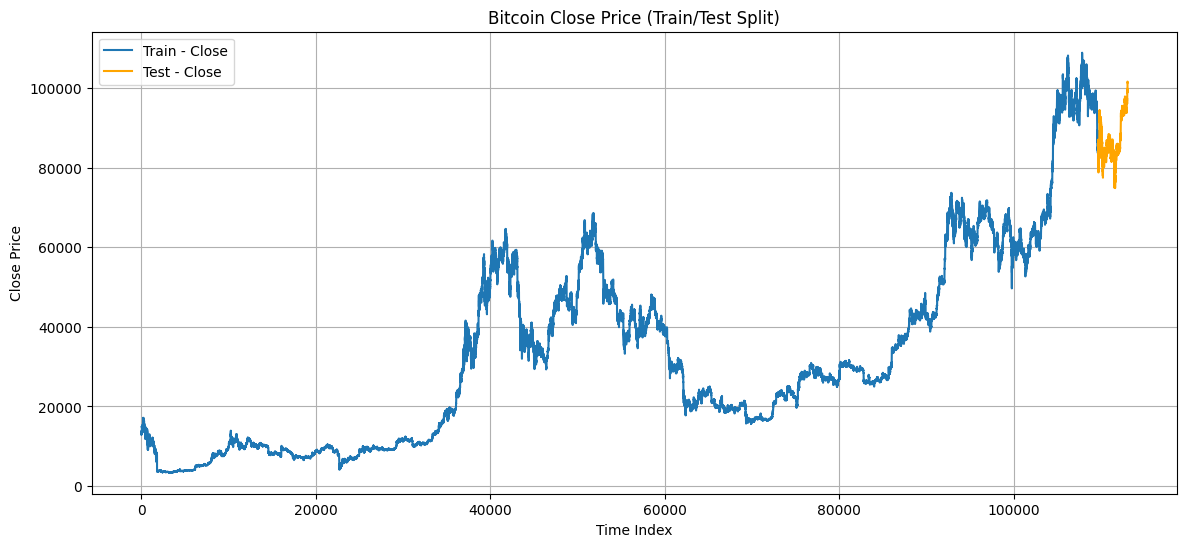

In [88]:
plt.figure(figsize=(14, 6))
plt.plot(train['close'].values, label='Train - Close')
plt.plot(range(train_size, len(btc30)), test['close'].values, label='Test - Close', color='orange')
plt.title('Bitcoin Close Price (Train/Test Split)')
plt.xlabel('Time Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
features = [col for col in train.columns if col not in ['target', 'timestamp']]
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

In [90]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

# Model
xgb = XGBRegressor(random_state=42)

# Random Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0.5, 1.0, 1.5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [101]:
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [93]:
y_pred = best_model.predict(X_test)

In [94]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [95]:
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 4659522.8040
Root Mean Squared Error (RMSE): 2158.5928
Mean Absolute Error (MAE): 1700.0409
R² Score: 0.8303


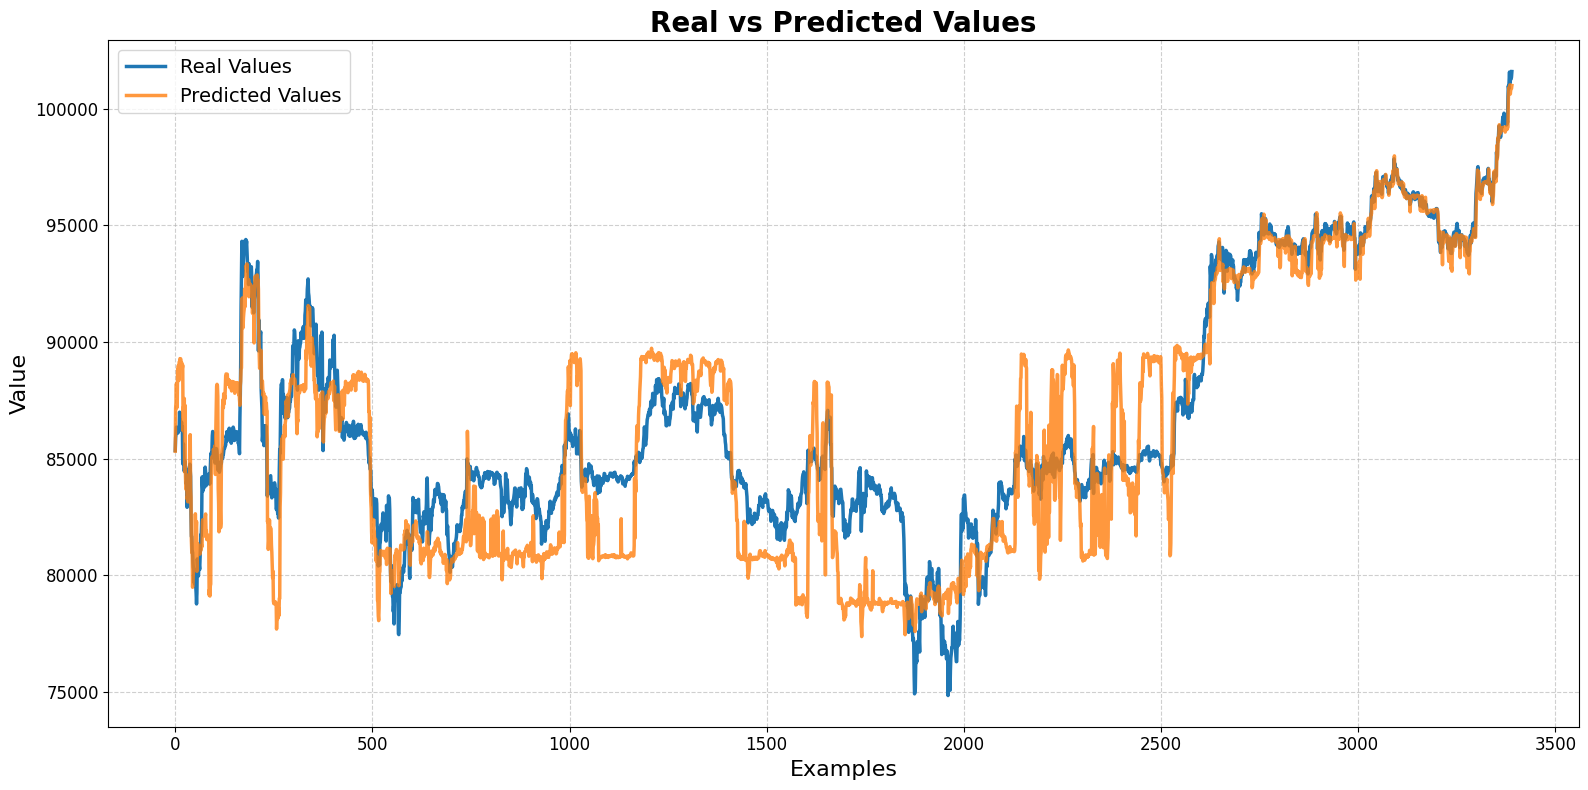

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(y_test.values, label="Real Values", linewidth=2.5)
plt.plot(y_pred, label="Predicted Values", linewidth=2.5, alpha=0.8)
plt.title("Real vs Predicted Values", fontsize=20, fontweight='bold')
plt.xlabel("Examples", fontsize=16)
plt.ylabel("Value", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()


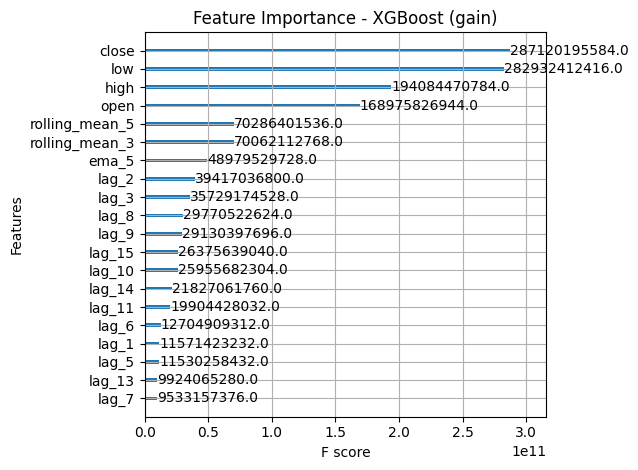

In [102]:
import xgboost as xgb
xgb.plot_importance(best_model, max_num_features=20, importance_type='gain')
plt.title("Feature Importance - XGBoost (gain)")
plt.tight_layout()
plt.show()